In [11]:
import numpy as np 
import pandas as pd 
import cv2
from PIL import Image 
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import ResNet50

In [2]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 25
IMG_DIR = pathlib.Path('G:\Github\standford-dogs\cropped')
TRAIN_DIR = 'G:/Github/standford-dogs/cropped/train'
VAL_DIR = 'G:/Github/standford-dogs/cropped/validation'

Specifiy model

In [5]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2,
                                             zoom_range = 0.4
                                                )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)


In [6]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')

Found 16464 images belonging to 120 classes.
Found 4116 images belonging to 120 classes.


In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import tensorflow.keras as keras

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

for layer in resnet.layers:
    layer.trainable = False
    
resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

num_classes = 120

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               123000    
Total params: 26,858,488
Trainable params: 3,270,776
Non-trainable params: 23,587,712
____________________________________

We chose to use resnet50 as feature extraction, hence adding pooling layer

In [12]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                              restore_best_weights=False
                                              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=1e-3,min_lr = 1e-6,
                                   )

In [13]:
model.compile(optimizer = adam, 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [14]:
model.fit(train_generator,steps_per_epoch=np.ceil(float(16464) / float(BATCH_SIZE)),
                        epochs = 100,callbacks=[early_stop,reduce_lr],
                          validation_steps=np.ceil(float(4116) / float(BATCH_SIZE)),
                        validation_data = validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 659.0 steps, validate for 165.0 steps
Epoch 1/100
659/659 [==============================] - 323s 489ms/step - loss: 4.8365 - accuracy: 0.0754 - f1_score: 0.0690 - val_loss: 2.2698 - val_accuracy: 0.4332 - val_f1_score: 0.3965
Epoch 2/100
659/659 [==============================] - 232s 351ms/step - loss: 2.8647 - accuracy: 0.2892 - f1_score: 0.2763 - val_loss: 1.3149 - val_accuracy: 0.6084 - val_f1_score: 0.5879
Epoch 3/100
659/659 [==============================] - 233s 354ms/step - loss: 2.2499 - accuracy: 0.4028 - f1_score: 0.3944 - val_loss: 1.0934 - val_accuracy: 0.6664 - val_f1_score: 0.6549
Epoch 4/100
659/659 [==============================] - 236s 358ms/step - loss: 1.9823 - accuracy: 0.4569 - f1_score: 0.4483 - val_loss: 0.9735 - val_accuracy: 0.7087 - val_f1_score: 0.6931
Epoch 5/100
659/659 [==============================] - 242s 368ms/step - loss: 1.8096 - accuracy: 0.5014 - f1_score: 0.4936 - val_loss: 0.9028 - v

659/659 [==============================] - 216s 327ms/step - loss: 0.7841 - accuracy: 0.7561 - f1_score: 0.7524 - val_loss: 0.6748 - val_accuracy: 0.7964 - val_f1_score: 0.7901
Epoch 43/100
658/659 [============================>.] - ETA: 0s - loss: 0.7861 - accuracy: 0.7550 - f1_score: 0.7520
Epoch 00043: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
659/659 [==============================] - 215s 327ms/step - loss: 0.7859 - accuracy: 0.7550 - f1_score: 0.7520 - val_loss: 0.6739 - val_accuracy: 0.7947 - val_f1_score: 0.7894
Epoch 44/100
659/659 [==============================] - 215s 327ms/step - loss: 0.7677 - accuracy: 0.7635 - f1_score: 0.7595 - val_loss: 0.6732 - val_accuracy: 0.7930 - val_f1_score: 0.7877
Epoch 45/100
659/659 [==============================] - 215s 326ms/step - loss: 0.7678 - accuracy: 0.7653 - f1_score: 0.7617 - val_loss: 0.6695 - val_accuracy: 0.7918 - val_f1_score: 0.7861
Epoch 46/100
659/659 [==============================] - 216s 327ms/st

In [15]:
def get_diagnostic_plot(model,name):
    training_loss = model.history.history[name]
    test_loss = model.history.history[f'val_{name}']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend([f'Training {name}', f'Val {name}'])
    plt.xlabel('Epoch')
    plt.ylabel(name)

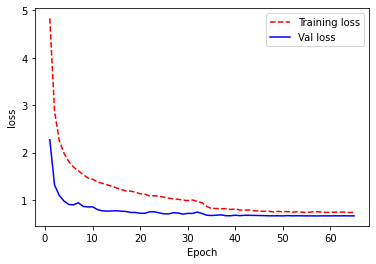

In [16]:
get_diagnostic_plot(model,'loss')

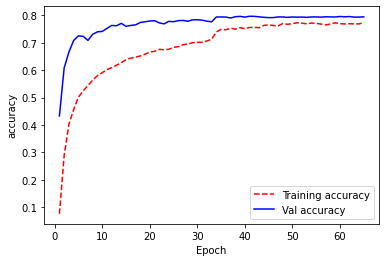

In [17]:
get_diagnostic_plot(model,'accuracy')

In [18]:
save_path = 'G:/Github/Dogs_breed_classification/resnet50_2/'
tf.keras.models.save_model(model,save_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: G:/Github/Dogs_breed_classification/resnet50_2/assets


The model using feature extraction only is not ideal. The performance is ok but it is not achieving its best for resnet 50 models

We will try to unfreeze resnet 50 and train again..

Meanwhile, we can also explore: deeper models resnet 101,152 or other architectures that is supposed to work better than Resnet50 (Xception/Inception/InceptionResNetV2)